In [1]:
import env
import actor
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
path_to_data = 'train.xlsx'
environment = env.DataCenterEnv(path_to_data)
print(environment.price_values.shape)

(1096, 24)


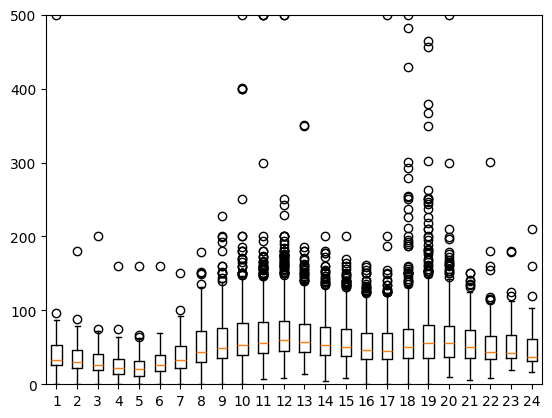

In [3]:
plt.boxplot(environment.price_values)
plt.ylim(0,500)
plt.show()

In [4]:
# Parameters
alpha = 0.1  # Learning rate
gamma = 1  # Discount factor
epsilon = 1  # Exploration rate (start)
epsilon_decay_rate = 0.999
min_epsilon_rate = 0.1
num_bins_price = 21  # Discretization bins for price
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
        110, 120, 130, 140, 150, 160, 170, 180, 190, 200, float('inf')]
num_hours = 24
actions = [-1, -0.5, 0, 0.5, 1]  # Discrete actions
num_episodes = 100
max_steps = len(environment.timestamps)

In [5]:
Q = np.zeros((num_bins_price, num_hours, len(actions)))

In [15]:
aggregate_reward = 0
for episode in range(num_episodes):
    state = environment.reset()
    for t in range(max_steps):
        # Choose action using epsilon-greedy policy
        _, price, hour, _ = state
        price_bin_index = np.digitize(price, bins) - 1
        hour_index = int(hour-1)
        if np.random.rand() < epsilon:
            action_idx = random.randrange(len(actions)) # Explore
        else:
            action_idx = np.argmax(Q[price_bin_index, hour_index, :]) # Exploit

        # Take action, observe reward and next state
        action = actions[action_idx]
        next_state, reward, terminated = environment.step(action)
        aggregate_reward += reward
        _, next_price, next_hour, _ = next_state
        next_price_bin_index = np.digitize(next_price, bins) - 1
        next_hour_index = int(next_hour-1)

        # Update Q-value
        best_next_action = np.argmax(Q[next_price_bin_index, next_hour_index, :])
        Q[price_bin_index, hour_index, action_idx] += alpha * (reward + gamma * Q[next_price_bin_index, next_hour_index, best_next_action] - Q[price_bin_index, hour_index, action_idx])

        # Transition to next state
        state = next_state

        # Update epsilon value
        epsilon = epsilon * epsilon_decay_rate
        if epsilon < min_epsilon_rate:
            epsilon = min_epsilon_rate

In [16]:
mean_aggregate_reward = aggregate_reward / num_episodes
mean_aggregate_reward

np.float64(-220040.34990000218)

In [ ]:
# Test the Q-learning agent
num_test_episodes = 10  # Number of test episodes
total_rewards = []

for episode in range(num_test_episodes):
    state = environment.reset()
    episode_reward = 0

    for t in range(max_steps):
        # Extract state variables
        _, price, hour, _ = state
        price_bin_index = np.digitize(price, bins) - 1
        hour_index = int(hour-1)

        # Select the best action (greedy policy)
        best_action_index = np.argmax(Q[price_bin_index, hour_index, :])
        best_action = actions[best_action_index]

        # Take the action
        next_state, reward, terminated = environment.step(best_action)
        #print(reward)
        episode_reward += reward

        # Transition to the next state
        state = next_state

        # Check termination
        if terminated:
            break

    # Record total reward for this episode
    total_rewards.append(episode_reward)

# Calculate average reward over test episodes
average_test_reward = np.mean(total_rewards)
print("Average Test Reward:", average_test_reward)

0.0
0.0
0.0
0.0
-0.1
-0.1
-0.0
0.04000000000000001
-0.0
-31.549999999999997
-0.0
-0.0
-0.0
-70.05
-75.0
-100.0
-81.7
-277.7
-379.90000000000003
-331.1
-379.90000000000003
-330.0
-364.79999999999995
-306.5
0.0
0.0
-45.05
30.0
-90.0
-74.5
132.0
-0.0
119.84000000000002
158.4
-0.0
-499.3
-0.0
-460.09999999999997
-375.7
-364.5
-379.90000000000003
-530.0
-596.9
-500.90000000000003
-500.0
-362.2
-310.9
-298.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-499.90000000000003
-470.0
-432.1
-439.90000000000003
-480.0
-570.0
-609.9
-555.1
-517.7
-345.09999999999997
-393.1
-380.5
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-459.6
-0.0
-423.5
-400.09999999999997
-380.0
-426.59999999999997
-530.0
-589.9
-535.0
-440.09999999999997
-350.0
-344.6
-315.7
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-498.40000000000003
-0.0
-479.4
-400.6
-380.0
-386.1
-498.40000000000003
-530.0
-459.09999999999997
-367.40000000000003
-296.1
-306.1
-275.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
-159.95
-0.0


In [26]:
epsilon = 1
epsilon_decay = 0.99

for i in range(1000):
    epsilon = epsilon * epsilon_decay
    print(epsilon)

0.99
0.9801
0.9702989999999999
0.96059601
0.9509900498999999
0.9414801494009999
0.9320653479069899
0.92274469442792
0.9135172474836407
0.9043820750088043
0.8953382542587163
0.8863848717161291
0.8775210229989678
0.8687458127689781
0.8600583546412883
0.8514577710948754
0.8429431933839266
0.8345137614500874
0.8261686238355865
0.8179069375972307
0.8097278682212583
0.8016305895390458
0.7936142836436553
0.7856781408072188
0.7778213593991465
0.7700431458051551
0.7623427143471035
0.7547192872036325
0.7471720943315961
0.7397003733882802
0.7323033696543974
0.7249803359578534
0.7177305325982748
0.7105532272722921
0.7034476949995692
0.6964132180495735
0.6894490858690777
0.682554595010387
0.6757290490602831
0.6689717585696803
0.6622820409839835
0.6556592205741436
0.6491026283684022
0.6426116020847181
0.6361854860638709
0.6298236312032323
0.6235253948912
0.617290140942288
0.6111172395328651
0.6050060671375365
0.5989560064661611
0.5929664464014994
0.5870367819374844
0.5811664141181095
0.5753547499769